In [2]:
spark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
%matplotlib inline
import json
import sparknlp
import pandas as pd
import numpy as np
from sparknlp.pretrained import PretrainedPipeline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

In [4]:
#import sparknlp

#spark = sparknlp.start()

In [5]:
spark = SparkSession.builder.config("spark.driver.memory", "60g").config("spark.kryoserializer.buffer.max", "2000M")\
.config("spark.serializer ", "org.apache.spark.serializer.KryoSerializer")\
.config("spark.sql.broadcastTimeout",  "360000")\
.getOrCreate()

In [6]:
sparknlp.start()

In [81]:
df = spark.read.option("multiline","true").option("header", "true").option("ignoreTrailingWhiteSpace","true").option("ignoreLeadingWhiteSpace", "true").option("inferSchema", "true").csv("gs://bigdata_project_hksv/tweetData/*.csv")

In [8]:
df.show(5)

+-------------------+----------+--------+-----+--------------+----------+--------------------+
|           tweet_id|     tdate|   ttime|tlang|tcountry_place|month_year|               tweet|
+-------------------+----------+--------+-----+--------------+----------+--------------------+
|1263392875682967558|2020-05-21|08:55:08|   en|          NULL|   2020-05|Coronavirus infec...|
|1263392876622471168|2020-05-21|08:55:09|   en|          NULL|   2020-05|@colz261 I think ...|
|1263392876744126469|2020-05-21|08:55:09|   en|          NULL|   2020-05|PTI_News: 70-year...|
|1263392876844720128|2020-05-21|08:55:09|   en|          NULL|   2020-05|Video shows emoti...|
|1263392878245617664|2020-05-21|08:55:09|   en|          NULL|   2020-05|Trump should be t...|
+-------------------+----------+--------+-----+--------------+----------+--------------------+
only showing top 5 rows



In [9]:
df1 = df.dropna(thresh=1, subset=('tweet'))
df1 = df1.filter(df1.tlang == "en")

In [10]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType



In [11]:
df1.show(10)

+-------------------+----------+--------+-----+--------------+----------+--------------------+
|           tweet_id|     tdate|   ttime|tlang|tcountry_place|month_year|               tweet|
+-------------------+----------+--------+-----+--------------+----------+--------------------+
|1263392875682967558|2020-05-21|08:55:08|   en|          NULL|   2020-05|Coronavirus infec...|
|1263392876622471168|2020-05-21|08:55:09|   en|          NULL|   2020-05|@colz261 I think ...|
|1263392876744126469|2020-05-21|08:55:09|   en|          NULL|   2020-05|PTI_News: 70-year...|
|1263392876844720128|2020-05-21|08:55:09|   en|          NULL|   2020-05|Video shows emoti...|
|1263392878245617664|2020-05-21|08:55:09|   en|          NULL|   2020-05|Trump should be t...|
|1263392878472114176|2020-05-21|08:55:09|   en|          NULL|   2020-05|I am waiting for ...|
|1263392878614786048|2020-05-21|08:55:09|   en|          NULL|   2020-05|If you're worried...|
|1263392878618968064|2020-05-21|08:55:09|   en|   

In [12]:
df2 = df1.withColumn('tweet1',regexp_replace(col('tweet'), '@', ''))
df2 = df2.withColumn('tweet2',regexp_replace(col('tweet1'), '#', ''))
df2 = df2.withColumn('tweet2',regexp_replace(col('tweet2'), 'RT', ''))
df2 = df2.withColumn('tweet2',regexp_replace(col('tweet2'), ':', ''))
df2 = df2.withColumn('tweet2',regexp_replace(col('tweet2'), 'http\S+', ''))

In [13]:
df2.select(col('tweet2')).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet2                                                                                                                                                                                                                                                                                                     |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Coronavirus infections have peaked in much of the rich world, but until there is a vaccine or

In [14]:
pipeline = PretrainedPipeline("analyze_sentimentdl_use_twitter")

analyze_sentimentdl_use_twitter download started this may take some time.
Approx size to download 935.1 MB
[ | ]analyze_sentimentdl_use_twitter download started this may take some time.
Approximate size to download 935.1 MB
Download done! Loading the resource.


[ / ]

[ — ]

2021-11-28 04:19:07.488113: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-28 04:19:07.980727: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz


[ — ]

[ | ]

[ / ]

[ — ]

[ \ ]

[OK!]


In [15]:
df3 = df2.select('tweet2')

In [16]:
df3.show()

+--------------------+
|              tweet2|
+--------------------+
|Coronavirus infec...|
|colz261 I think t...|
|PTI_News 70-year-...|
|Video shows emoti...|
|Trump should be t...|
|I am waiting for ...|
|If you're worried...|
|NHS and social ca...|
|realDonaldTrump A...|
|199 is a lot sha!...|
|Stop demanding ex...|
|"""We still have ...|
|The latest The Te...|
|Report finds priv...|
|.EmileHeskeyUK ex...|
|LaylaMoran DavidH...|
|Factionalism in t...|
|Protective clothe...|
|The Scientist Beh...|
|I wonder if every...|
+--------------------+
only showing top 20 rows



In [17]:
df3 = df2.withColumnRenamed("tweet2", "text")

In [18]:
df_result = pipeline.transform(df3)

In [19]:
df_result.show(5)

+-------------------+----------+--------+-----+--------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           tweet_id|     tdate|   ttime|tlang|tcountry_place|month_year|               tweet|              tweet1|                text|            document| sentence_embeddings|           sentiment|
+-------------------+----------+--------+-----+--------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|1263392875682967558|2020-05-21|08:55:08|   en|          NULL|   2020-05|Coronavirus infec...|Coronavirus infec...|Coronavirus infec...|[{document, 0, 18...|[{sentence_embedd...|[{category, 0, 18...|
|1263392876622471168|2020-05-21|08:55:09|   en|          NULL|   2020-05|@colz261 I think ...|colz261 I think t...|colz261 I think t...|[{document, 0, 12...|[{sentence_embedd...|[{category, 0, 12...|


In [20]:
df_result.printSchema()

root
 |-- tweet_id: string (nullable = true)
 |-- tdate: string (nullable = true)
 |-- ttime: string (nullable = true)
 |-- tlang: string (nullable = true)
 |-- tcountry_place: string (nullable = true)
 |-- month_year: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- tweet1: string (nullable = true)
 |-- text: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence_embeddings: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |

In [21]:
df_result.select('sentiment.result').show()

+----------+
|    result|
+----------+
|[negative]|
|[negative]|
|[negative]|
|[positive]|
| [neutral]|
|[positive]|
|[positive]|
|[negative]|
| [neutral]|
|[positive]|
|[negative]|
|[positive]|
|[positive]|
|[negative]|
|[negative]|
|[negative]|
|[positive]|
|[negative]|
|[positive]|
|[positive]|
+----------+
only showing top 20 rows



In [22]:
df_result2 = df_result.selectExpr("tweet_id","tdate","tcountry_place","month_year","text","explode(sentiment.metadata) sentiments", "sentiment").selectExpr("tweet_id","tdate","tcountry_place","month_year","text","explode(sentiments)", "sentiment.result result")

In [23]:
df_result2 = df_result2.filter((df_result2.key != 'sentence') & (df_result2.key != 'negative'))

In [24]:
df_result2 = df_result2.drop('key')

In [25]:
df_result2.show()

+-------------------+----------+--------------+----------+--------------------+-------------+----------+
|           tweet_id|     tdate|tcountry_place|month_year|                text|        value|    result|
+-------------------+----------+--------------+----------+--------------------+-------------+----------+
|1263392875682967558|2020-05-21|          NULL|   2020-05|Coronavirus infec...|4.6534226E-12|[negative]|
|1263392876622471168|2020-05-21|          NULL|   2020-05|colz261 I think t...|          0.0|[negative]|
|1263392876744126469|2020-05-21|          NULL|   2020-05|PTI_News 70-year-...|          0.0|[negative]|
|1263392876844720128|2020-05-21|          NULL|   2020-05|Video shows emoti...|    0.7801526|[positive]|
|1263392878245617664|2020-05-21|          NULL|   2020-05|Trump should be t...|   0.40801293| [neutral]|
|1263392878472114176|2020-05-21|          NULL|   2020-05|I am waiting for ...|   0.80718654|[positive]|
|1263392878614786048|2020-05-21|          NULL|   2020-

In [26]:
df_result3 = df_result2.withColumnRenamed("value", "sentiment_score")

In [27]:
df_result3 = df_result3.withColumnRenamed("result", "sentiment")

In [28]:
df_result3.show()

+-------------------+----------+--------------+----------+--------------------+---------------+----------+
|           tweet_id|     tdate|tcountry_place|month_year|                text|sentiment_score| sentiment|
+-------------------+----------+--------------+----------+--------------------+---------------+----------+
|1263392875682967558|2020-05-21|          NULL|   2020-05|Coronavirus infec...|  4.6534226E-12|[negative]|
|1263392876622471168|2020-05-21|          NULL|   2020-05|colz261 I think t...|            0.0|[negative]|
|1263392876744126469|2020-05-21|          NULL|   2020-05|PTI_News 70-year-...|            0.0|[negative]|
|1263392876844720128|2020-05-21|          NULL|   2020-05|Video shows emoti...|      0.7801526|[positive]|
|1263392878245617664|2020-05-21|          NULL|   2020-05|Trump should be t...|     0.40801293| [neutral]|
|1263392878472114176|2020-05-21|          NULL|   2020-05|I am waiting for ...|     0.80718654|[positive]|
|1263392878614786048|2020-05-21|     

In [29]:
df_result3 = df_result3.select(df_result3.tweet_id,df_result3.tdate, df_result3.tcountry_place, df_result3.month_year,df_result3.text, df_result3.sentiment_score, df_result3.sentiment[0])

In [30]:
df_result3 = df_result3.withColumnRenamed("sentiment[0]", "sentiment")

In [31]:
df_result3.show()

+-------------------+----------+--------------+----------+--------------------+---------------+---------+
|           tweet_id|     tdate|tcountry_place|month_year|                text|sentiment_score|sentiment|
+-------------------+----------+--------------+----------+--------------------+---------------+---------+
|1263392875682967558|2020-05-21|          NULL|   2020-05|Coronavirus infec...|  4.6534226E-12| negative|
|1263392876622471168|2020-05-21|          NULL|   2020-05|colz261 I think t...|            0.0| negative|
|1263392876744126469|2020-05-21|          NULL|   2020-05|PTI_News 70-year-...|            0.0| negative|
|1263392876844720128|2020-05-21|          NULL|   2020-05|Video shows emoti...|      0.7801526| positive|
|1263392878245617664|2020-05-21|          NULL|   2020-05|Trump should be t...|     0.40801293|  neutral|
|1263392878472114176|2020-05-21|          NULL|   2020-05|I am waiting for ...|     0.80718654| positive|
|1263392878614786048|2020-05-21|          NULL

In [32]:
df_result4 = df_result3.groupby(df_result3.sentiment).count().sort('sentiment').orderBy(["sentiment"], ascending=False)

In [33]:
df_result4.printSchema()

root
 |-- sentiment: string (nullable = true)
 |-- count: long (nullable = false)



In [34]:
df_con = df_result3.select("tcountry_place", "sentiment").groupby("tcountry_place", "sentiment").count().sort('count').orderBy(['count'], ascending = False)

In [35]:
df_text = df_result3.select("text", "sentiment")

In [36]:
df_month = df_result3.select("month_year", "sentiment").groupby("month_year", "sentiment").count().sort('count').orderBy(['month_year'], ascending = False)

In [37]:
df_con.printSchema()

root
 |-- tcountry_place: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- count: long (nullable = false)



In [38]:
df_month.printSchema()

root
 |-- month_year: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- count: long (nullable = false)



In [ ]:
pdf_sent = df_result4.toPandas()

<AxesSubplot:xlabel='sentiment', ylabel='count'>

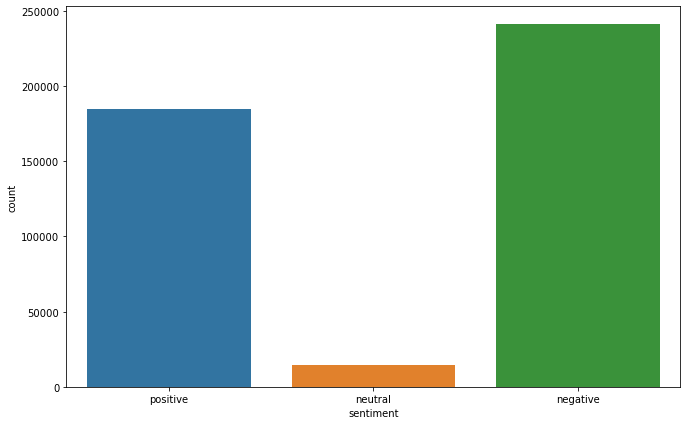

In [41]:
fig, ax = plt.subplots(figsize=(11,7))  
sns.barplot(x='sentiment', y='count', data=pdf_sent, ax=ax)

In [49]:
pdf_con = df_con.toPandas()

In [56]:
pdf_con = pdf_con[pdf_con['tcountry_place'] != "NULL"]

In [57]:
pdf_con

,tcountry_place,sentiment,count
3,US,negative,3174
4,US,positive,3069
5,GB,positive,934
6,GB,negative,897
7,IN,negative,476
...,...,...,...
306,FI,positive,1
307,IS,negative,1
308,AF,positive,1
309,SZ,negative,1


<AxesSubplot:xlabel='tcountry_place', ylabel='count'>

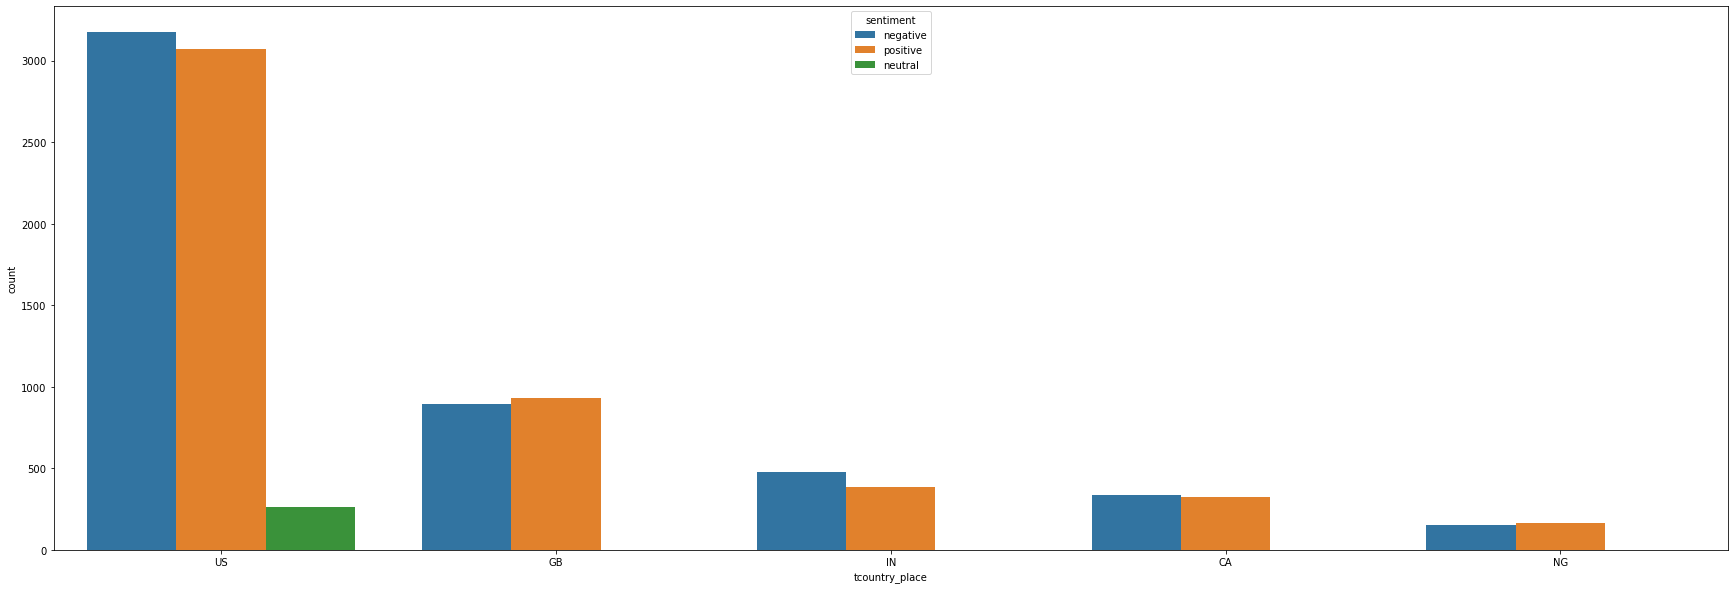

In [71]:
fig, ax = plt.subplots(figsize=(30,10))
sns.barplot(x= 'tcountry_place', y='count', hue='sentiment', data = pdf_con.iloc[0:11], ax=ax)

In [39]:
df_result5 = df_result3.select("tweet_id", "sentiment")

In [40]:
df_result5_pos = df_result5.filter(df_result5.sentiment == "positive")
df_result5_neg = df_result5.filter(df_result5.sentiment == "negative")

In [ ]:
pdf_pos = df_result5_pos.toPandas()

In [50]:
pdf_pos['tweet_id'] = pdf_pos['tweet_id'].astype(str).astype(int)

In [80]:
pandf1 = pd.read_csv("gs://bigdata_project_hksv/tweetData/*.csv")

In [52]:
pandf1 = pandf1.dropna(thresh=1, subset=['tweet'])
pandf1 = pandf1[pandf1['tlang']== 'en']

In [53]:
pandf1['tweet_id'].astype(str).astype(int)

0         1263392875682967558
1         1263392876622471168
2         1263392876744126469
3         1263392876844720128
4         1263392878245617664
                 ...         
566784    1263734914945613824
566785    1263734915167686657
566786    1263734916359032833
566789    1263734918347198464
566790    1263734918707924992
Name: tweet_id, Length: 440380, dtype: int64

In [54]:
pandf2 = pandf1.drop(['tdate', 'ttime', 'ttime', 'tcountry_place', 'month_year'], axis =1 )

In [55]:
pandf_pos = pd.merge(pdf_pos, pandf2[['tweet_id', 'tweet']],
                       how='left', on=['tweet_id'])

In [58]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def show_wordcloud_pos(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1,
        colormap='winter'
    ).generate(str(data))

    fig = plt.figure(1, figsize=(30,30))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

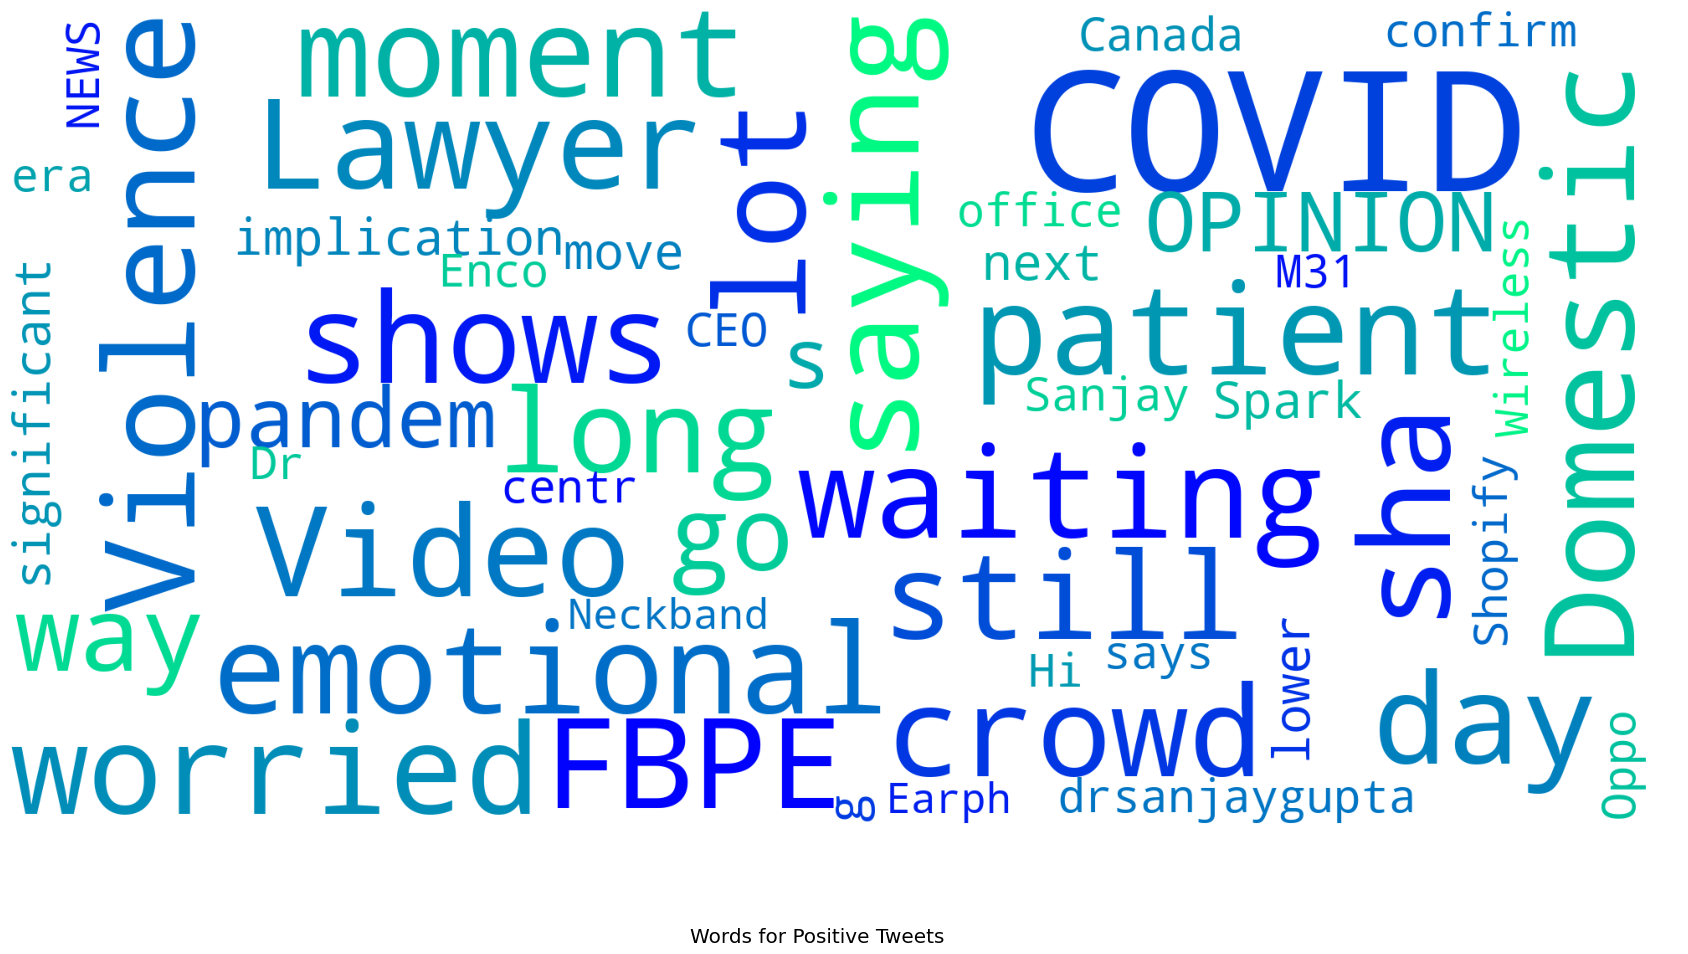

In [59]:
show_wordcloud_pos(pandf_pos['tweet'], title = 'Words for Positive Tweets')

In [ ]:
pdf_neg = df_result5_neg.toPandas()

In [74]:
pdf_neg['tweet_id'] = pdf_neg['tweet_id'].astype(str).astype(int)

In [75]:
pandf_neg = pd.merge(pdf_neg, pandf2[['tweet_id', 'tweet']],
                       how='left', on=['tweet_id'])

In [77]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def show_wordcloud_neg(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1,
        colormap='autumn'
    ).generate(str(data))

    fig = plt.figure(1, figsize=(30,30))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

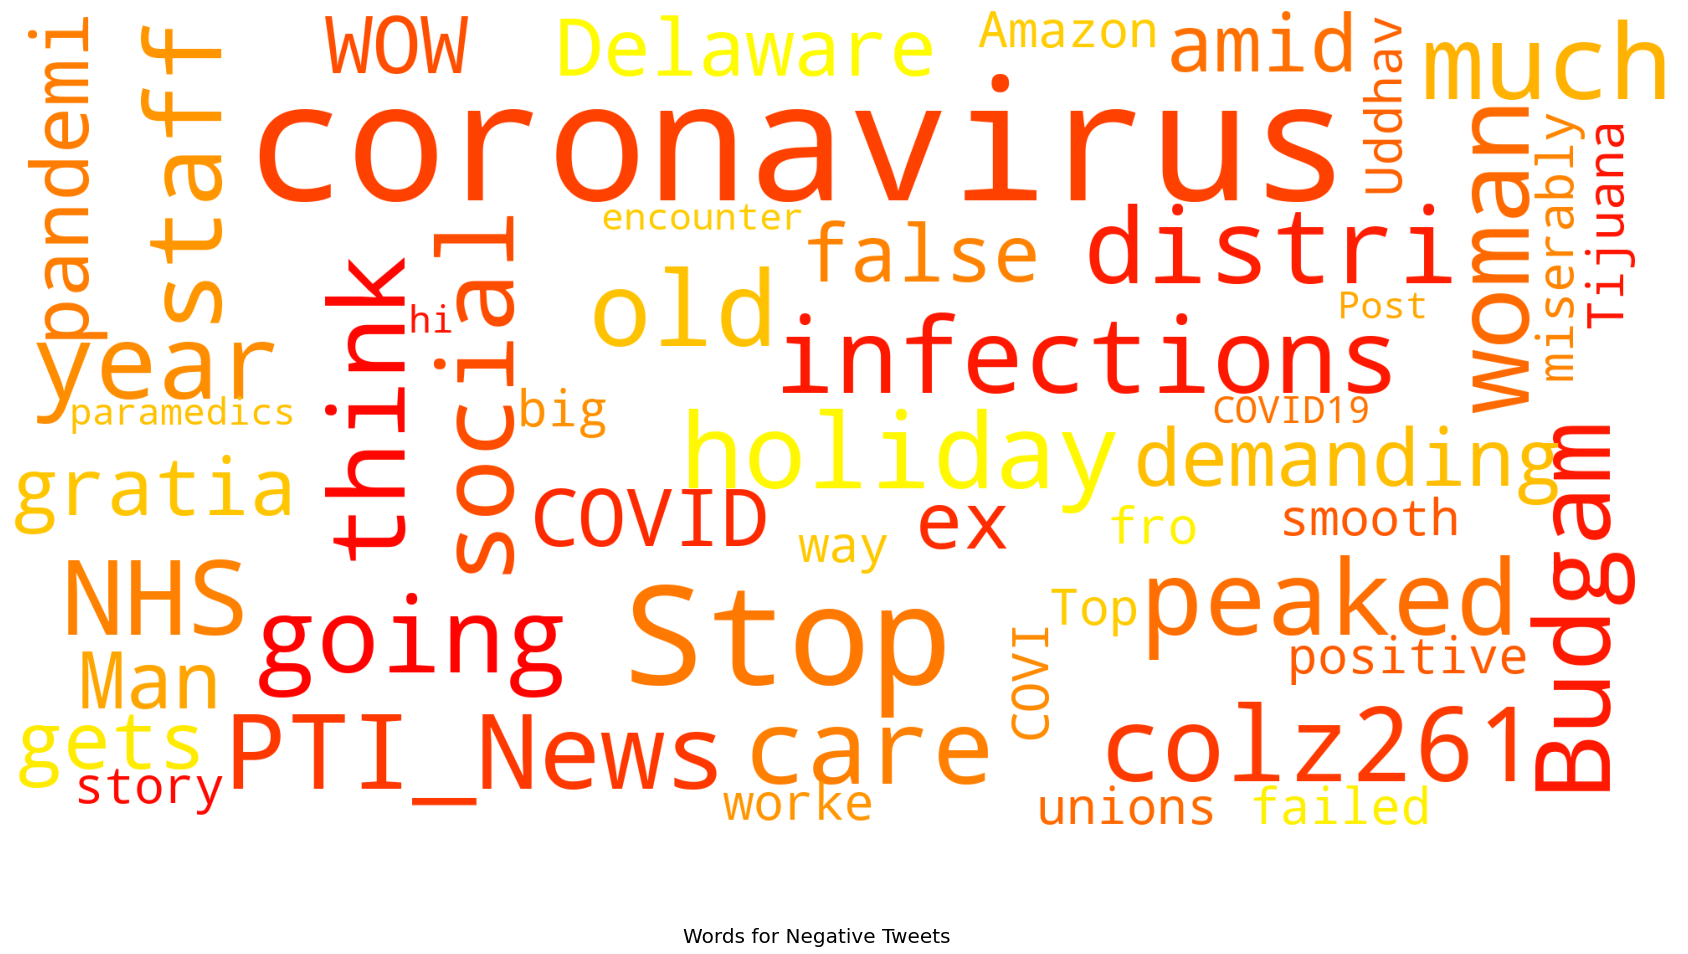

In [79]:
show_wordcloud_neg(pandf_neg['tweet'], title = 'Words for Negative Tweets')